In [1]:
import os
from io import StringIO
from time import sleep
from datetime import date

import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:
def fetch_index(ticker):
    print(f"Fetching index data for {ticker}")
    base = f"https://iss.moex.com/iss/history/engines/stock/markets/index/securities/{ticker}.csv"

    frames = []
    for year in range(1997, date.today().year + 1):
        start = 0
        while True:
            params = {
                "from": f"{year}-01-01",
                "till": f"{year}-12-31",
                "start": start,
                "limit": 100,          
                "iss.only": "history"   # чтобы в CSV пришла только таблица history
            }
            for i in range(3):  # несколько попыток на случай временных проблем с сетью
                try:
                    resp = requests.get(base, params=params, timeout=30)
                    if resp.status_code == 200:
                        txt = resp.text
                        break
                except Exception as e:
                    continue
            else:
                # не удалось скачать после нескольких попыток
                print(f"{ticker}: Failed to download {year} start={start} after several attempts. Status code: {resp.status_code}")
                print(e)
                break  
            
            try:
                df_part = pd.read_csv(StringIO(txt), sep=';', skiprows=2)
            except Exception as e:
                print(f"{ticker}: Error reading {year} start={start}: {e}")
                break

            if df_part.empty:
                break

            # иногда ISS в history может вернуть несколько BOARDID — оставим всё и потом агрегнём по дате
            frames.append(df_part)

            # если получили меньше лимита — страница последняя
            if len(df_part) < params["limit"]:
                break

            start += params["limit"]
            sleep(0.7)  # вежливый троттлинг
    
    if len(frames) == 0:
        return None
    
    df = pd.concat(frames, ignore_index=True)
    keep_cols = ["TRADEDATE", "CLOSE", "VOLUME"]
    df = df[keep_cols]
    df.columns = ["Date", "Close", "Volume"]
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date")

    full_idx = pd.date_range(df["Date"].min(), df["Date"].max(), freq="D")
    df_calendar = (df.set_index("Date")
                 .reindex(full_idx)
                 .ffill()
                 .rename_axis("Date")
                 .reset_index())
    
    return df_calendar

Общая капа рынка акций РФ - 51300 млрд руб

MOEX учитывает капу неочевидно (free-float * какойто коэфф ограничивающий вес)

In [3]:
csv_text = """
Тикер,   Описание,             N компаний, TR брутто, Наличие ETF, дата base, дата TR, Расчетная капа млрд руб

MOEXBMI, широкий рынок,        100,        нет,       нет,         2011,      null,     6996

IMOEX,   примерно топ 50,      43,         MCFTR,     оба,         1997,      2004,    6219

MCXSM,   средняя и малая капа, 54,         MESMTR,    есть TR,     2012,      2013,    688

MOEXCN,  потреб сектор,        18,         MECNTR,    есть TR,     2004,      2013,    181

MOEXFN,  фин сектор,           13,         MEFNTR,    есть TR,     2004,      2013,    383

MOEXOG,  нефтегаз,             11,         MEOGTR,    нет,         2004,      2013,    1983

MOEXEU,  электроэнергия,       14,         MEEUTR,    нет,         2004,      2013,    125

MOEXTL,  телеком,              4,          METLTR,    нет,         2004,      2013,    16

MOEXMM,  металлы и добыча,     15,         MEMMTR,    нет,         2004,      2013,    570

MOEXCH,  химия,                5,          MECHTR,    нет,         2006,      2013,    127

MOEXTN,  транспорт,            5,          METNTR,    нет,         2007,      2013,    67

MOEXIT,  айти,                 9,          MEITTR,    нет,         2020,      2020,    135

MOEXRE,  стройка,              3,          MERETR,    нет,         2020,      2020,    31
"""

In [5]:
df_indices_meta = pd.read_csv(StringIO(csv_text.strip()))
# strip the spaces from column names
df_indices_meta.columns = [col.strip() for col in df_indices_meta.columns]
# strip the spaces from values
df_indices_meta = df_indices_meta.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_indices_meta.to_csv(os.path.join("..", "data", "indices", "indices_meta.csv"), index=False)
df_indices_meta

C:\Users\koles\AppData\Local\Temp\ipykernel_25940\3428614066.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_indices_meta = df_indices_meta.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,Тикер,Описание,N компаний,TR брутто,Наличие ETF,дата base,дата TR,Расчетная капа млрд руб
0,MOEXBMI,широкий рынок,100,нет,нет,2011,null,6996
1,IMOEX,примерно топ 50,43,MCFTR,оба,1997,2004,6219
2,MCXSM,средняя и малая капа,54,MESMTR,есть TR,2012,2013,688
3,MOEXCN,потреб сектор,18,MECNTR,есть TR,2004,2013,181
4,MOEXFN,фин сектор,13,MEFNTR,есть TR,2004,2013,383
5,MOEXOG,нефтегаз,11,MEOGTR,нет,2004,2013,1983
6,MOEXEU,электроэнергия,14,MEEUTR,нет,2004,2013,125
7,MOEXTL,телеком,4,METLTR,нет,2004,2013,16
8,MOEXMM,металлы и добыча,15,MEMMTR,нет,2004,2013,570
9,MOEXCH,химия,5,MECHTR,нет,2006,2013,127


Fetching index data for MOEXBMI
Saved MOEXBMI to ..\data\indices\MOEXBMI.csv
Fetching index data for IMOEX
Saved IMOEX to ..\data\indices\IMOEX.csv
Fetching index data for MCFTR
Saved MCFTR to ..\data\indices\MCFTR.csv
Fetching index data for MCXSM
Saved MCXSM to ..\data\indices\MCXSM.csv
Fetching index data for MESMTR
Saved MESMTR to ..\data\indices\MESMTR.csv
Fetching index data for MOEXCN
Saved MOEXCN to ..\data\indices\MOEXCN.csv
Fetching index data for MECNTR
Saved MECNTR to ..\data\indices\MECNTR.csv
Fetching index data for MOEXFN
Saved MOEXFN to ..\data\indices\MOEXFN.csv
Fetching index data for MEFNTR
Saved MEFNTR to ..\data\indices\MEFNTR.csv
Fetching index data for MOEXOG
Saved MOEXOG to ..\data\indices\MOEXOG.csv
Fetching index data for MEOGTR
Saved MEOGTR to ..\data\indices\MEOGTR.csv
Fetching index data for MOEXEU
Saved MOEXEU to ..\data\indices\MOEXEU.csv
Fetching index data for MEEUTR
Saved MEEUTR to ..\data\indices\MEEUTR.csv
Fetching index data for MOEXTL
Saved MOEXTL 

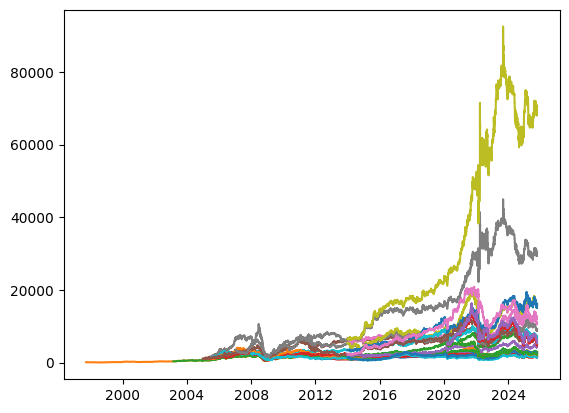

In [7]:
for idx, row in df_indices_meta.iterrows():
    ticker = row["Тикер"]
    df_index = fetch_index(ticker)
    if df_index is not None:
        out_path = os.path.join("..", "data", "indices", f"{ticker}.csv")
        df_index.to_csv(out_path, index=False)
        print(f"Saved {ticker} to {out_path}")
        plt.plot(df_index["Date"], df_index["Close"])
    else:
        print(f"No data for {ticker}")
    
    if row['TR брутто'].strip().lower() != 'нет':
        ticker_tr = row['TR брутто'].strip()
        df_index_tr = fetch_index(ticker_tr)
        if df_index_tr is not None:
            out_path_tr = os.path.join("..", "data", "indices", f"{ticker_tr}.csv")
            df_index_tr.to_csv(out_path_tr, index=False)
            print(f"Saved {ticker_tr} to {out_path_tr}")
            plt.plot(df_index_tr["Date"], df_index_tr["Close"], label=f"{ticker} TR")
        else:
            print(f"No data for {ticker_tr}")